# EDA Project Source Code
## Exploratory Data Analysis and Visualization with Python (90-800) - Fall 2022
### Name: Jeremy Bruton, Heng Jiang, Angela Yang
#### Due date:  Thursday, December 7th, 2023 (before 11:59 PM)


#### 4 Refined Questions that will answer this story:
1. Is NYC’s population increase outpacing the increase in available housing, which causes a housing shortage?
2. Are hosts with 10+ properties increasing in NYC, which causes arbitrage?
3. Are there any associations between Airbnb arbitrage and housing prices?
4. Does this association vary across boroughs of different income levels?

In [1]:
#import necessary packages

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopandas as gpd
import shapely
from shapely.geometry import Point
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
import geodatasets
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

# Step 1: Cleaning/Formatting Each Dataset

In [2]:
# load datasets here from csv files. All csv files are included in the submission. Otherwise they can also be found at links provided above each line of code that loads in that specific dataset.
# New York City Airbnb Listings data can be downloaded from http://insideairbnb.com/get-the-data/ under the listings.csv.gz file name New York City section
NYC_Listings = pd.read_csv('listings.csv')

# New York City Airbnb reviews data can be downloaded from http://insideairbnb.com/get-the-data/ under the reviews.csv.gz file name in the New York City section
NYC_Reviews = pd.read_csv('reviews.csv')

# New York City Median Rent Sales data can be downloaded from https://streeteasy.com/blog/data-dashboard/?agg=Total&metric=Inventory&type=Rentals&bedrooms=Any%20Bedrooms&property=Any%20Property%20Type&minDate=2010-01-01&maxDate=2023-10-01&area=Flatiron,Brooklyn%20Heights
NYC_MedRent = pd.read_csv('medianAskingRent_All.csv')

# New York City Neighborhood Poverty rate data can be downloaded from https://a816-dohbesp.nyc.gov/IndicatorPublic/beta/data-explorer/economic-conditions/?id=103#display=summary
NYC_Poverty = pd.read_csv('Neighborhood_poverty.csv')

# New York City Inventories for Rental and houses data can be downloaded from https://streeteasy.com/blog/data-dashboard/[object%20Object]?agg=Total&metric=Inventory&type=Sales&bedrooms=Any%20Bedrooms&property=Any%20Property%20Type&minDate=2010-01-01&maxDate=2023-10-01&area=Flatiron,Brooklyn%20Heights
NYC_Inventory = pd.read_csv('inventory.csv')

# Resident Population in Kings County Data (Brooklyn) can be downloaded from https://fred.stlouisfed.org/series/NYKING7POP
Brooklyn_Pop = pd.read_csv('NYKING7POP.csv')

# Resident Population in Bronx County Data (Bronx) can be downloaded from https://fred.stlouisfed.org/series/NYBRON5POP
Bronx_Pop = pd.read_csv('NYBRON5POP.csv')

# Resident Population in New York County Data (Manhattan) can be downloaded from https://fred.stlouisfed.org/series/NYNEWY1POP
Manhattan_Pop = pd.read_csv('NYNEWY1POP.csv')

# Resident Population in Queens County Data (Queens) can be downloaded from https://fred.stlouisfed.org/series/NYQUEE1POP
Queens_Pop = pd.read_csv('NYQUEE1POP.csv')

# Resident Population in Richmond County Data (Staten Island) can be downloaded from https://fred.stlouisfed.org/series/NYRICH5POP
Staten_Pop = pd.read_csv('NYRICH5POP.csv')
# New York City Neighborhood Demographics data can be downloaded from https://a816-dohbesp.nyc.gov/IndicatorPublic/beta/data-explorer/social-conditions/?id=2325#display=summary
NYC_Demograph = pd.read_csv('Demographics.csv')

# New York City Neighborhood High School Graduation rates data can be downloaded from https://a816-dohbesp.nyc.gov/IndicatorPublic/beta/data-explorer/social-conditions/?id=2334#display=summary
NYC_HSGrad = pd.read_csv('Graduated_high_school.csv')
# New York City Neighborhood Household Crowding data can be downloaded from https://a816-dohbesp.nyc.gov/IndicatorPublic/data-explorer/economic-conditions/?id=15#display=summary
NYC_HouseCrowding = pd.read_csv('Householdcrowding.csv')


In [3]:
listing_map = NYC_Listings.copy()
review_map = NYC_Reviews.copy()
poverty_table = NYC_Poverty.copy()

## 1.1. Listings Data 

In [4]:
# Column names for the listings dataset

NYC_Listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [5]:
# Given our proposed questions, we will only keep our variables of interest.

keep_vars = ['id','neighbourhood_group_cleansed','host_id']

NYC_Listings = NYC_Listings[keep_vars]

NYC_Listings.rename(columns={'id':'listing_id','neighbourhood_group_cleansed': 'Borough'},inplace=True)

NYC_Listings.head(5)

,listing_id,Borough,host_id
0,9630344,Brooklyn,47783628
1,3533741,Manhattan,17791294
2,9731039,Queens,50213378
3,21736164,Brooklyn,4298654
4,22280002,Brooklyn,67373899


## 1.2. Reviews Data

In [6]:
NYC_Reviews.head()

,listing_id,date
0,2595,2009-11-21
1,2595,2009-12-05
2,2595,2009-12-10
3,2595,2010-04-09
4,2595,2010-05-25


In [7]:
# The level of analysis for this project is at the borough and month level as we will gauge Airbnb popularity over time by how many Airbnb reviews each borough recieves per month.
# Therefore, we must count how many reviews were in a given month. We start by putting the date column in a datetime format and putting it as the index. We will do resampling in the next code chunk.

NYC_Reviews['date'] = pd.to_datetime(NYC_Reviews['date'], format='%Y-%m-%d')
NYC_Reviews.index = NYC_Reviews.date
NYC_Reviews = NYC_Reviews.drop('date', axis=1)
NYC_Reviews.head()

,listing_id
date,
2009-11-21,2595
2009-12-05,2595
2009-12-10,2595
2010-04-09,2595
2010-05-25,2595


In [8]:
# Group the reviews data to see the number of reviews each listing got per month per year using the resample method. This can take a bit to run (60 or so seconds).
# https://stackoverflow.com/questions/19384532/get-statistics-for-each-group-such-as-count-mean-etc-using-pandas-groupby

NYC_Reviews = NYC_Reviews.groupby('listing_id').resample("M").size().reset_index(name='counts')
NYC_Reviews['date'] = pd.to_datetime(NYC_Reviews['date'], format='%Y-%m-%d')
NYC_Reviews.index = NYC_Reviews.date
NYC_Reviews['Month'] = NYC_Reviews.index.month
NYC_Reviews['Year'] = NYC_Reviews.index.year
NYC_Reviews = NYC_Reviews.drop('date', axis=1)
# We now have a df that shows the number of reviews each listing got each month and each year. We will group this to the borough level later after merging the reviews and listings dataset.
NYC_Reviews.head()

,listing_id,counts,Month,Year
date,,,,
2009-11-30,2595,1,11,2009
2009-12-31,2595,2,12,2009
2010-01-31,2595,0,1,2010
2010-02-28,2595,0,2,2010
2010-03-31,2595,0,3,2010


In [9]:
# Checking for missing values in the reviews dataset

NYC_Reviews.isnull().sum()

listing_id    0
counts        0
Month         0
Year          0
dtype: int64

## 1.3. Median Rent Data

In [10]:
# Examining the monthly median rent. This dataset is in wide format so we will need to melt it to long data so that we can merge it later on.

NYC_MedRent.head()

,areaName,Borough,areaType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,...,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10
0,All Downtown,Manhattan,submarket,3200.0,3200.0,3020.0,3100.0,3100.0,3200.0,3195.0,...,4850.0,4958.0,4800.0,4886.0,4950.0,4950.0,4900.0,4830.0,4850.0,4760.0
1,All Midtown,Manhattan,submarket,2875.0,2800.0,2800.0,2850.0,2895.0,2950.0,3000.0,...,4389.0,4495.0,4495.0,4578.0,4500.0,4500.0,4495.0,4500.0,4495.0,4400.0
2,All Upper East Side,Manhattan,submarket,2450.0,2450.0,2400.0,2500.0,2550.0,2550.0,2595.0,...,3900.0,4000.0,4000.0,3995.0,4000.0,4000.0,4000.0,3995.0,4000.0,3995.0
3,All Upper Manhattan,Manhattan,submarket,1825.0,1800.0,1795.0,1800.0,1823.0,1850.0,1875.0,...,2650.0,2699.0,2725.0,2800.0,2832.0,2950.0,2900.0,2900.0,2895.0,2800.0
4,All Upper West Side,Manhattan,submarket,2895.0,2800.0,2750.0,2800.0,2800.0,2795.0,2800.0,...,4450.0,4445.0,4495.0,4500.0,4463.0,4400.0,4500.0,4500.0,4500.0,4495.0


In [11]:
# Making a list of value columns to be used for melting

date_cols= NYC_MedRent.columns.tolist()
date_cols= date_cols[3:]

In [12]:
# Melting the MedRent dataset

NYC_MedRent_melted = pd.melt(NYC_MedRent,id_vars=['Borough'],value_vars=date_cols)
NYC_MedRent_melted.rename(columns={'variable':'Date','value':'MedRent'},inplace=True)
NYC_MedRent_melted.head()

,Borough,Date,MedRent
0,Manhattan,2010-01,3200.0
1,Manhattan,2010-01,2875.0
2,Manhattan,2010-01,2450.0
3,Manhattan,2010-01,1825.0
4,Manhattan,2010-01,2895.0


In [13]:
# Get melted data into the level needed for merging which is the month and borough level as right now each row represents a neighborhood observation so we will average the median rent for each neighborhood to get an average borough median rent
NYC_MedRent_Averages = NYC_MedRent_melted.groupby(['Borough','Date'])['MedRent'].mean().reset_index()
NYC_MedRent_Averages.head()

,Borough,Date,MedRent
0,Bronx,2010-01,1421.00
1,Bronx,2010-02,1410.75
2,Bronx,2010-03,1402.00
3,Bronx,2010-04,1495.25
4,Bronx,2010-05,1575.00


In [14]:
# Split the Date column into a month and year column to make the eventual merges easier

NYC_MedRent_Averages['Date'] = pd.to_datetime(NYC_MedRent_Averages['Date'], format='%Y-%m')
NYC_MedRent_Averages.index = NYC_MedRent_Averages.Date
NYC_MedRent_Averages['Month'] = NYC_MedRent_Averages.index.month
NYC_MedRent_Averages['Year'] = NYC_MedRent_Averages.index.year
NYC_MedRent_Averages = NYC_MedRent_Averages.drop('Date', axis=1)
NYC_MedRent_Averages.head()

,Borough,MedRent,Month,Year
Date,,,,
2010-01-01,Bronx,1421.00,1,2010
2010-02-01,Bronx,1410.75,2,2010
2010-03-01,Bronx,1402.00,3,2010
2010-04-01,Bronx,1495.25,4,2010
2010-05-01,Bronx,1575.00,5,2010


In [15]:
# Converting the Borough column to a categorical variable

NYC_MedRent_Averages['Borough'] = NYC_MedRent_Averages['Borough'].astype('category')

In [16]:
# Checking for missing values in the MedianRent dataset

NYC_MedRent_Averages.isnull().sum()

Borough     0
MedRent    29
Month       0
Year        0
dtype: int64

In [17]:
# To deal with the missing data we will perform a backwards fill
NYC_MedRent_Averages['MedRent']=NYC_MedRent_Averages['MedRent'].fillna(method='bfill')

In [18]:
# Check the percentages again
percentages = NYC_MedRent_Averages.isnull().sum() * 100 / NYC_MedRent_Averages.shape[0]
missing_data = pd.DataFrame({'Percent Missing': percentages})
missing_data = missing_data.sort_values(by='Percent Missing', ascending=False)
missing_data

,Percent Missing
Borough,0.0
MedRent,0.0
Month,0.0
Year,0.0


## 1.4. Poverty Rate Data

In [19]:
# Only keep the Borough data from the poverty dataset

NYC_Poverty = NYC_Poverty.loc[NYC_Poverty['GeoType'] == 'Borough']

NYC_Poverty.head()

,Time,GeoType,GeoID,GeoRank,Geography,Number,Percent
353,2017-21,Borough,1,1,Bronx,"379,954",26.5
354,2017-21,Borough,2,1,Brooklyn,"504,813",18.8
355,2017-21,Borough,3,1,Manhattan,"252,233",15.6
356,2017-21,Borough,4,1,Queens,"270,107",11.4
357,2017-21,Borough,5,1,Staten Island,"50,282",10.3


In [20]:
# Rename the 'Geography' column to 'Borough'
# Change the Borough Column to a Categorical datatype

NYC_Poverty = NYC_Poverty.rename(columns={'Geography': 'Borough'})
NYC_Poverty['Borough'] = NYC_Poverty['Borough'].astype('category')

# Drop the columns we do not need for analysis

NYC_Poverty = NYC_Poverty.drop(['GeoType','GeoID','GeoRank', 'Number'], axis=1)
NYC_Poverty.head()

,Time,Borough,Percent
353,2017-21,Bronx,26.5
354,2017-21,Brooklyn,18.8
355,2017-21,Manhattan,15.6
356,2017-21,Queens,11.4
357,2017-21,Staten Island,10.3


In [21]:
# This data comes from the American Community Survey ACS which reports its year column in blocks of 4. For instance 2015-2019, 2016-2020, 2017-2021.
# To make it easier to merge with the other data we will classify the year column based on the last year included in the survey. e.g 2015-2019 -> 2019 and 2016-2020 -> 2020

NYC_Poverty['Time'] = NYC_Poverty['Time'].apply(lambda x: x[:2] + x[5:])
NYC_Poverty.head()

,Time,Borough,Percent
353,2021,Bronx,26.5
354,2021,Brooklyn,18.8
355,2021,Manhattan,15.6
356,2021,Queens,11.4
357,2021,Staten Island,10.3


In [22]:
# Rename the percent column to PovertyRate
NYC_Poverty.rename(columns={'Percent':'PovertyRate'},inplace=True)

# Rename the Time column to Year
NYC_Poverty.rename(columns={'Time':'Year'},inplace=True)

# Convert the Year column to an int
NYC_Poverty['Year'] = NYC_Poverty['Year'].apply(lambda x: int(x))

NYC_Poverty.head()

,Year,Borough,PovertyRate
353,2021,Bronx,26.5
354,2021,Brooklyn,18.8
355,2021,Manhattan,15.6
356,2021,Queens,11.4
357,2021,Staten Island,10.3


In [23]:
# Checking for missing values in the MedianRent dataset

NYC_Poverty.isnull().sum()

Year           0
Borough        0
PovertyRate    0
dtype: int64

## 1.5. inventory Data

In [24]:
NYC_Inventory.head()

,areaName,Borough,areaType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,...,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11
0,All Downtown,Manhattan,submarket,2915,2962,3104,3091,3041,3024,2885,...,2248,2426,2525,2706,2601,2413,2278,2514,2646,2528
1,All Midtown,Manhattan,submarket,2238,2347,2502,2550,2524,2498,2400,...,1787,1940,2000,2103,2038,1946,1894,2074,2177,2147
2,All Upper East Side,Manhattan,submarket,2201,2297,2463,2520,2466,2414,2291,...,1718,1875,1925,1998,1918,1769,1681,1876,2036,1931
3,All Upper Manhattan,Manhattan,submarket,1154,1205,1247,1300,1240,1204,1176,...,653,743,769,776,795,750,748,781,830,809
4,All Upper West Side,Manhattan,submarket,1465,1456,1534,1607,1601,1605,1513,...,1144,1280,1309,1411,1323,1213,1133,1249,1326,1277


In [25]:
# Check the column names of the dataset

NYC_Inventory.columns.tolist()

['areaName',
 'Borough',
 'areaType',
 '2010-01',
 '2010-02',
 '2010-03',
 '2010-04',
 '2010-05',
 '2010-06',
 '2010-07',
 '2010-08',
 '2010-09',
 '2010-10',
 '2010-11',
 '2010-12',
 '2011-01',
 '2011-02',
 '2011-03',
 '2011-04',
 '2011-05',
 '2011-06',
 '2011-07',
 '2011-08',
 '2011-09',
 '2011-10',
 '2011-11',
 '2011-12',
 '2012-01',
 '2012-02',
 '2012-03',
 '2012-04',
 '2012-05',
 '2012-06',
 '2012-07',
 '2012-08',
 '2012-09',
 '2012-10',
 '2012-11',
 '2012-12',
 '2013-01',
 '2013-02',
 '2013-03',
 '2013-04',
 '2013-05',
 '2013-06',
 '2013-07',
 '2013-08',
 '2013-09',
 '2013-10',
 '2013-11',
 '2013-12',
 '2014-01',
 '2014-02',
 '2014-03',
 '2014-04',
 '2014-05',
 '2014-06',
 '2014-07',
 '2014-08',
 '2014-09',
 '2014-10',
 '2014-11',
 '2014-12',
 '2015-01',
 '2015-02',
 '2015-03',
 '2015-04',
 '2015-05',
 '2015-06',
 '2015-07',
 '2015-08',
 '2015-09',
 '2015-10',
 '2015-11',
 '2015-12',
 '2016-01',
 '2016-02',
 '2016-03',
 '2016-04',
 '2016-05',
 '2016-06',
 '2016-07',
 '2016-08',
 '

In [26]:
# Drop irrelevent columns

NYC_Inventory=NYC_Inventory.drop(['areaName','areaType'],axis=1)
NYC_Inventory.columns.tolist()

['Borough',
 '2010-01',
 '2010-02',
 '2010-03',
 '2010-04',
 '2010-05',
 '2010-06',
 '2010-07',
 '2010-08',
 '2010-09',
 '2010-10',
 '2010-11',
 '2010-12',
 '2011-01',
 '2011-02',
 '2011-03',
 '2011-04',
 '2011-05',
 '2011-06',
 '2011-07',
 '2011-08',
 '2011-09',
 '2011-10',
 '2011-11',
 '2011-12',
 '2012-01',
 '2012-02',
 '2012-03',
 '2012-04',
 '2012-05',
 '2012-06',
 '2012-07',
 '2012-08',
 '2012-09',
 '2012-10',
 '2012-11',
 '2012-12',
 '2013-01',
 '2013-02',
 '2013-03',
 '2013-04',
 '2013-05',
 '2013-06',
 '2013-07',
 '2013-08',
 '2013-09',
 '2013-10',
 '2013-11',
 '2013-12',
 '2014-01',
 '2014-02',
 '2014-03',
 '2014-04',
 '2014-05',
 '2014-06',
 '2014-07',
 '2014-08',
 '2014-09',
 '2014-10',
 '2014-11',
 '2014-12',
 '2015-01',
 '2015-02',
 '2015-03',
 '2015-04',
 '2015-05',
 '2015-06',
 '2015-07',
 '2015-08',
 '2015-09',
 '2015-10',
 '2015-11',
 '2015-12',
 '2016-01',
 '2016-02',
 '2016-03',
 '2016-04',
 '2016-05',
 '2016-06',
 '2016-07',
 '2016-08',
 '2016-09',
 '2016-10',
 '20

In [27]:
# We are looking at Borough level, so we sum up the supplies across areas within each borough

NYC_Inventory=NYC_Inventory.groupby('Borough').sum().reset_index()
NYC_Inventory

,Borough,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,...,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11
0,Bronx,1149,1195,1262,1356,1220,1220,1216,1168,1160,...,1324,1394,1338,1337,1364,1334,1311,1288,1336,1378
1,Brooklyn,9531,9837,10248,11196,10641,10539,10581,10368,10764,...,10640,11711,11653,12334,11990,11501,11249,11723,12431,12283
2,Manhattan,29999,30885,32614,33260,32660,32283,30849,29660,30888,...,22680,24826,25614,27010,26061,24303,23230,25518,27089,26132
3,Queens,2616,2799,2913,3075,3156,3393,3609,3345,3351,...,8017,8185,8112,8603,8511,8301,8556,8538,8955,8760
4,Staten Island,49,51,59,55,49,46,41,43,55,...,289,297,297,311,316,299,292,285,286,279


In [28]:
# retrieve the data column names and save it as a list for melting 

date_cols=NYC_Inventory.columns.tolist()
date_cols=date_cols[1:]
date_cols

['2010-01',
 '2010-02',
 '2010-03',
 '2010-04',
 '2010-05',
 '2010-06',
 '2010-07',
 '2010-08',
 '2010-09',
 '2010-10',
 '2010-11',
 '2010-12',
 '2011-01',
 '2011-02',
 '2011-03',
 '2011-04',
 '2011-05',
 '2011-06',
 '2011-07',
 '2011-08',
 '2011-09',
 '2011-10',
 '2011-11',
 '2011-12',
 '2012-01',
 '2012-02',
 '2012-03',
 '2012-04',
 '2012-05',
 '2012-06',
 '2012-07',
 '2012-08',
 '2012-09',
 '2012-10',
 '2012-11',
 '2012-12',
 '2013-01',
 '2013-02',
 '2013-03',
 '2013-04',
 '2013-05',
 '2013-06',
 '2013-07',
 '2013-08',
 '2013-09',
 '2013-10',
 '2013-11',
 '2013-12',
 '2014-01',
 '2014-02',
 '2014-03',
 '2014-04',
 '2014-05',
 '2014-06',
 '2014-07',
 '2014-08',
 '2014-09',
 '2014-10',
 '2014-11',
 '2014-12',
 '2015-01',
 '2015-02',
 '2015-03',
 '2015-04',
 '2015-05',
 '2015-06',
 '2015-07',
 '2015-08',
 '2015-09',
 '2015-10',
 '2015-11',
 '2015-12',
 '2016-01',
 '2016-02',
 '2016-03',
 '2016-04',
 '2016-05',
 '2016-06',
 '2016-07',
 '2016-08',
 '2016-09',
 '2016-10',
 '2016-11',
 '20

In [29]:
# melt the dataset to a long format for analysis and visualization
NYC_Inventory_melted=pd.melt(NYC_Inventory,id_vars=['Borough'],value_vars=date_cols)
NYC_Inventory_melted.rename(columns={'variable':'Date','value':'housing_supply'},inplace=True)
NYC_Inventory_melted

,Borough,Date,housing_supply
0,Bronx,2010-01,1149
1,Brooklyn,2010-01,9531
2,Manhattan,2010-01,29999
3,Queens,2010-01,2616
4,Staten Island,2010-01,49
...,...,...,...
830,Bronx,2023-11,1378
831,Brooklyn,2023-11,12283
832,Manhattan,2023-11,26132
833,Queens,2023-11,8760


In [30]:
# check data types

NYC_Inventory_melted.dtypes

Borough           object
Date              object
housing_supply     int64
dtype: object

In [31]:
# modify data types

NYC_Inventory_melted['Date']=pd.to_datetime(NYC_Inventory_melted['Date'],format='%Y-%m')
NYC_Inventory_melted['Borough']=NYC_Inventory_melted['Borough'].astype('category')
NYC_Inventory_melted

,Borough,Date,housing_supply
0,Bronx,2010-01-01,1149
1,Brooklyn,2010-01-01,9531
2,Manhattan,2010-01-01,29999
3,Queens,2010-01-01,2616
4,Staten Island,2010-01-01,49
...,...,...,...
830,Bronx,2023-11-01,1378
831,Brooklyn,2023-11-01,12283
832,Manhattan,2023-11-01,26132
833,Queens,2023-11-01,8760


In [32]:
# Extract 'year' from date

NYC_Inventory_melted.index = NYC_Inventory_melted.Date
NYC_Inventory_melted['Year'] = NYC_Inventory_melted.index.year
NYC_Inventory_melted['Month'] = NYC_Inventory_melted.index.month
NYC_Inventory_melted=NYC_Inventory_melted.drop(['Date'],axis=1)
NYC_Inventory_melted.reset_index(inplace=True)
NYC_Inventory_melted.head()

,Date,Borough,housing_supply,Year,Month
0,2010-01-01,Bronx,1149,2010,1
1,2010-01-01,Brooklyn,9531,2010,1
2,2010-01-01,Manhattan,29999,2010,1
3,2010-01-01,Queens,2616,2010,1
4,2010-01-01,Staten Island,49,2010,1


In [33]:
# check for missing values

NYC_Inventory_melted.isnull().sum()

Date              0
Borough           0
housing_supply    0
Year              0
Month             0
dtype: int64

## 1.6. Population Data

In [34]:
# Checking the structures of population datasets, with Brooklyn as the sample
Brooklyn_Pop.head()

,DATE,NYKING7POP
0,2000-01-01,2465.754
1,2001-01-01,2471.557
2,2002-01-01,2477.361
3,2003-01-01,2483.164
4,2004-01-01,2497.859


In [35]:
# Checking the data types of population datasets, with Brooklyn as the sample

Brooklyn_Pop.dtypes

DATE           object
NYKING7POP    float64
dtype: object

In [36]:
# Convert the date column into date time format
Brooklyn_Pop['DATE']=pd.to_datetime(Brooklyn_Pop['DATE'], format='%Y-%m-%d')

# Extract 'year' from date
Brooklyn_Pop.index = Brooklyn_Pop.DATE
Brooklyn_Pop['Year'] = Brooklyn_Pop.index.year
Brooklyn_Pop=Brooklyn_Pop.drop(['DATE'],axis=1)
Brooklyn_Pop.reset_index(inplace=True)
Brooklyn_Pop.head()

,DATE,NYKING7POP,Year
0,2000-01-01,2465.754,2000
1,2001-01-01,2471.557,2001
2,2002-01-01,2477.361,2002
3,2003-01-01,2483.164,2003
4,2004-01-01,2497.859,2004


In [37]:
# Drop the redundent date column and rename the columns.

Brooklyn_Pop=Brooklyn_Pop.drop(['DATE'],axis=1)
Brooklyn_Pop = Brooklyn_Pop.rename(columns={'NYKING7POP':'Brooklyn'})

# Only keep data from 2010 onwards.
Brooklyn_Pop = Brooklyn_Pop[Brooklyn_Pop['Year']>=2010]

Brooklyn_Pop

,Brooklyn,Year
10,2509.954,2010
11,2540.918,2011
12,2568.538,2012
13,2587.759,2013
14,2601.527,2014
15,2608.797,2015
16,2608.146,2016
17,2594.357,2017
18,2580.088,2018
19,2562.329,2019


In [38]:
# Repeat similar cleansing procedures to other population datasets
Bronx_Pop.head()

,DATE,NYBRON5POP
0,1970-01-01,1471.701
1,1971-01-01,1477.400
2,1972-01-01,1472.500
3,1973-01-01,1418.900
4,1974-01-01,1381.600


In [39]:
# Convert the date column into date time format
Bronx_Pop['DATE']=pd.to_datetime(Bronx_Pop['DATE'], format='%Y-%m-%d')

# Extract 'year' from date
Bronx_Pop.index = Bronx_Pop.DATE
Bronx_Pop['Year'] = Bronx_Pop.index.year
Bronx_Pop=Bronx_Pop.drop(['DATE'],axis=1)
Bronx_Pop.reset_index(inplace=True)
Bronx_Pop.head()

,DATE,NYBRON5POP,Year
0,1970-01-01,1471.701,1970
1,1971-01-01,1477.400,1971
2,1972-01-01,1472.500,1972
3,1973-01-01,1418.900,1973
4,1974-01-01,1381.600,1974


In [40]:
# Drop the redundent date column and rename the columns.

Bronx_Pop=Bronx_Pop.drop(['DATE'],axis=1)
Bronx_Pop = Bronx_Pop.rename(columns={'NYBRON5POP':'Bronx'})

# Only keep data from 2010 onwards.
Bronx_Pop = Bronx_Pop[Bronx_Pop['Year']>=2010]

Bronx_Pop

,Bronx,Year
40,1386.929,2010
41,1396.954,2011
42,1411.087,2012
43,1421.498,2013
44,1430.474,2014
45,1439.480,2015
46,1443.678,2016
47,1439.956,2017
48,1432.316,2018
49,1418.187,2019


In [41]:
Queens_Pop.head()

,DATE,NYQUEE1POP
0,1970-01-01,1987.174
1,1971-01-01,1990.900
2,1972-01-01,1985.000
3,1973-01-01,1958.100
4,1974-01-01,1945.600


In [42]:
# Convert the date column into date time format
Queens_Pop['DATE']=pd.to_datetime(Queens_Pop['DATE'], format='%Y-%m-%d')

# Extract 'year' from date
Queens_Pop.index = Queens_Pop.DATE
Queens_Pop['Year'] = Queens_Pop.index.year
Queens_Pop=Queens_Pop.drop(['DATE'],axis=1)
Queens_Pop.reset_index(inplace=True)
Queens_Pop.head()

,DATE,NYQUEE1POP,Year
0,1970-01-01,1987.174,1970
1,1971-01-01,1990.900,1971
2,1972-01-01,1985.000,1972
3,1973-01-01,1958.100,1973
4,1974-01-01,1945.600,1974


In [43]:
# Drop the redundent date column and rename the columns.

Queens_Pop=Queens_Pop.drop(['DATE'],axis=1)
Queens_Pop = Queens_Pop.rename(columns={'NYQUEE1POP':'Queens'})

# Only keep data from 2010 onwards.
Queens_Pop = Queens_Pop[Queens_Pop['Year']>=2010]

Queens_Pop

,Queens,Year
40,2234.574,2010
41,2255.261,2011
42,2271.920,2012
43,2286.788,2013
44,2298.234,2014
45,2305.252,2015
46,2306.249,2016
47,2295.226,2017
48,2275.286,2018
49,2253.942,2019


In [44]:
Manhattan_Pop.head()

,DATE,NYNEWY1POP
0,1970-01-01,1539.233
1,1971-01-01,1520.800
2,1972-01-01,1508.100
3,1973-01-01,1496.100
4,1974-01-01,1494.400


In [45]:
# Convert the date column into date time format
Manhattan_Pop['DATE']=pd.to_datetime(Manhattan_Pop['DATE'], format='%Y-%m-%d')

# Extract 'year' from date
Manhattan_Pop.index = Manhattan_Pop.DATE
Manhattan_Pop['Year'] = Manhattan_Pop.index.year
Manhattan_Pop = Manhattan_Pop.drop(['DATE'],axis=1)
Manhattan_Pop.reset_index(inplace=True)
Manhattan_Pop.head()

,DATE,NYNEWY1POP,Year
0,1970-01-01,1539.233,1970
1,1971-01-01,1520.800,1971
2,1972-01-01,1508.100,1972
3,1973-01-01,1496.100,1973
4,1974-01-01,1494.400,1974


In [46]:
# Drop the redundent date column and rename the columns.

Manhattan_Pop=Manhattan_Pop.drop(['DATE'],axis=1)
Manhattan_Pop = Manhattan_Pop.rename(columns={'NYNEWY1POP':'Manhattan'})

# Only keep data from 2010 onwards.
Manhattan_Pop = Manhattan_Pop[Manhattan_Pop['Year']>=2010]

Manhattan_Pop

,Manhattan,Year
40,1589.041,2010
41,1608.717,2011
42,1624.573,2012
43,1628.379,2013
44,1631.733,2014
45,1637.327,2015
46,1636.721,2016
47,1632.337,2017
48,1632.393,2018
49,1632.326,2019


In [47]:
Staten_Pop.head()

,DATE,NYRICH5POP
0,1970-01-01,295.443
1,1971-01-01,304.900
2,1972-01-01,309.700
3,1973-01-01,315.800
4,1974-01-01,320.200


In [48]:
# Convert the date column into date time format
Staten_Pop['DATE']=pd.to_datetime(Staten_Pop['DATE'], format='%Y-%m-%d')

# Extract 'year' from date
Staten_Pop.index = Staten_Pop.DATE
Staten_Pop['Year'] = Staten_Pop.index.year
Staten_Pop = Staten_Pop.drop(['DATE'],axis=1)
Staten_Pop.reset_index(inplace=True)
Staten_Pop.head()

,DATE,NYRICH5POP,Year
0,1970-01-01,295.443,1970
1,1971-01-01,304.900,1971
2,1972-01-01,309.700,1972
3,1973-01-01,315.800,1973
4,1974-01-01,320.200,1974


In [49]:
# Drop the redundent date column and rename the columns.

Staten_Pop = Staten_Pop.drop(['DATE'],axis=1)
Staten_Pop = Staten_Pop.rename(columns={'NYRICH5POP':'Staten Island'})

# Only keep data from 2010 onwards.
Staten_Pop = Staten_Pop[Staten_Pop['Year']>=2010]

Staten_Pop

,Staten Island,Year
40,469.607,2010
41,471.014,2011
42,470.597,2012
43,471.783,2013
44,471.899,2014
45,472.301,2015
46,474.160,2016
47,475.819,2017
48,476.531,2018
49,476.141,2019


In [50]:
# Merge the individual borough population datasets
NYC_Pop = pd.merge (Staten_Pop,Queens_Pop,on='Year')
NYC_Pop = NYC_Pop.merge(Manhattan_Pop,on='Year')
NYC_Pop = NYC_Pop.merge(Bronx_Pop,on='Year')
NYC_Pop = NYC_Pop.merge(Brooklyn_Pop,on='Year')
NYC_Pop = NYC_Pop.reindex(columns=['Year', 'Queens', 'Manhattan', 'Brooklyn','Bronx','Staten Island'])
NYC_Pop.head()

,Year,Queens,Manhattan,Brooklyn,Bronx,Staten Island
0,2010,2234.574,1589.041,2509.954,1386.929,469.607
1,2011,2255.261,1608.717,2540.918,1396.954,471.014
2,2012,2271.920,1624.573,2568.538,1411.087,470.597
3,2013,2286.788,1628.379,2587.759,1421.498,471.783
4,2014,2298.234,1631.733,2601.527,1430.474,471.899


In [51]:
# Melting the Dataset
bors= NYC_Pop.columns.tolist()
bors= bors[1:]
NYC_Pop = pd.melt(NYC_Pop,id_vars=['Year'],value_vars=bors)
NYC_Pop.rename(columns={'variable':'Borough','value':'Population'},inplace=True)
NYC_Pop.head()

,Year,Borough,Population
0,2010,Queens,2234.574
1,2011,Queens,2255.261
2,2012,Queens,2271.920
3,2013,Queens,2286.788
4,2014,Queens,2298.234


# Step 2: Merging Data

In [52]:
# The reviews dataset is the base dataset. That is what we will be merging data onto starting with the reviews and listings data.
# For reviews and listings data we will be merging using the listing_id as the common key
# Remove the 0 in host_id and convert it to a string 

Total_data = pd.merge(NYC_Reviews,NYC_Listings, on='listing_id')
Total_data['host_id'] = Total_data['host_id'].astype(int).astype(str)
#Total_data.to_csv('Attempt.csv', sep='\t', encoding='utf-8')
Total_data.head()

,listing_id,counts,Month,Year,Borough,host_id
0,2595,1,11,2009,Manhattan,2845
1,2595,2,12,2009,Manhattan,2845
2,2595,0,1,2010,Manhattan,2845
3,2595,0,2,2010,Manhattan,2845
4,2595,0,3,2010,Manhattan,2845


In [53]:
# We now want to count the number of reviews in each month that occured at a listing where that listing was owned by an ('arbitrage') owner who owned 10+ other listings  

# We first count for each month the number of total listings every host had in that particular month. We use the size command to count the number of rows for particular month with the same host. 
# For instance, if a host in month 11 of 2009 had a row with listing_id of 2556 and another row with listing_id of 2667 then they would have 2 total listings in that month.
host_monthly_listings = Total_data.groupby(['host_id', 'Month', 'Year']).size().reset_index(name='monthly_listings')

# We then look to find the months where there was a host who had 10+ listings
host_monthly_listings['is_arbitrage_month'] = host_monthly_listings['monthly_listings'] >= 10

# After that we want to merge this monthly listings dataset to our totaldata so that we have an indicator as to whether a host in a particular month was a high volume host
data_with_volume_info = pd.merge(Total_data, host_monthly_listings[['host_id', 'Month', 'Year', 'is_arbitrage_month']], on=['host_id', 'Month', 'Year'], how='left')

# Now we want to see the total reviews that were in each borough each month/year. This includes all reviews at all listings not just the 10+ host ones
total_reviews = data_with_volume_info.groupby(['Month', 'Year', 'Borough']).sum()['counts'].reset_index(name='total_reviews')

# Now we look at just the reviews that were in each borough each month/year that occurred at a listing where the host had 10+ other airbnbs at that time.
arbitrage_reviews = data_with_volume_info[data_with_volume_info['is_arbitrage_month']].groupby(['Month', 'Year', 'Borough']).sum()['counts'].reset_index(name='arbitrage_reviews')

# Now we merge these columns back to our total dataset
Total_data = pd.merge(total_reviews, arbitrage_reviews, on=['Month', 'Year', 'Borough'], how='left')

# We also fill in the NANs in arbitrage_reviews column with 0s as the NANs indicate that a particular month/borough combination did not contain any arbitrage reviews
Total_data['arbitrage_reviews'] = Total_data['arbitrage_reviews'].fillna(0)



In [54]:
Total_data = pd.merge(Total_data,NYC_MedRent_Averages, on=['Borough','Month','Year'])

In [55]:
# Merge the group data with the monthly median rent by Borough.
Airbnb_With_Rent = Total_data.copy()
Airbnb_With_Rent.tail()

,Month,Year,Borough,total_reviews,arbitrage_reviews,MedRent
791,12,2022,Bronx,1012,0.0,2087.833333
792,12,2022,Brooklyn,8581,142.0,3158.729167
793,12,2022,Manhattan,7333,1226.0,4452.361111
794,12,2022,Queens,4252,183.0,2428.421053
795,12,2022,Staten Island,316,0.0,2050.000000


In [56]:
# Merge the group data with the yearly Borough Poverty data.
Total_data = pd.merge(Total_data,NYC_Poverty, on=['Borough','Year'])
Total_data.head()

,Month,Year,Borough,total_reviews,arbitrage_reviews,MedRent,PovertyRate
0,1,2011,Brooklyn,29,0.0,2017.833333,22.1
1,2,2011,Brooklyn,21,0.0,1975.897436,22.1
2,3,2011,Brooklyn,34,0.0,1999.075000,22.1
3,4,2011,Brooklyn,50,0.0,2096.605263,22.1
4,5,2011,Brooklyn,76,0.0,2078.794872,22.1


In [57]:
# Merge the group data with the yearly Borough population data.

Total_data = pd.merge(Total_data,NYC_Pop, on=['Borough','Year'])
Total_data.head()

,Month,Year,Borough,total_reviews,arbitrage_reviews,MedRent,PovertyRate,Population
0,1,2011,Brooklyn,29,0.0,2017.833333,22.1,2540.918
1,2,2011,Brooklyn,21,0.0,1975.897436,22.1,2540.918
2,3,2011,Brooklyn,34,0.0,1999.075000,22.1,2540.918
3,4,2011,Brooklyn,50,0.0,2096.605263,22.1,2540.918
4,5,2011,Brooklyn,76,0.0,2078.794872,22.1,2540.918


In [58]:
# Merge the group data with the monthly Borough housing supply data.

Total_data = pd.merge(Total_data,NYC_Inventory_melted, on=['Borough','Year','Month'])
Total_data.head()

,Month,Year,Borough,total_reviews,arbitrage_reviews,MedRent,PovertyRate,Population,Date,housing_supply
0,1,2011,Brooklyn,29,0.0,2017.833333,22.1,2540.918,2011-01-01,10239
1,2,2011,Brooklyn,21,0.0,1975.897436,22.1,2540.918,2011-02-01,10272
2,3,2011,Brooklyn,34,0.0,1999.075000,22.1,2540.918,2011-03-01,10887
3,4,2011,Brooklyn,50,0.0,2096.605263,22.1,2540.918,2011-04-01,10971
4,5,2011,Brooklyn,76,0.0,2078.794872,22.1,2540.918,2011-05-01,11037


In [59]:
Total_data.columns

Index(['Month', 'Year', 'Borough', 'total_reviews', 'arbitrage_reviews',
       'MedRent', 'PovertyRate', 'Population', 'Date', 'housing_supply'],
      dtype='object')

In [60]:
Total_data = Total_data.reindex(columns=['Date', 'Year', 'Month', 'Borough','Population','total_reviews','arbitrage_reviews','MedRent','PovertyRate','housing_supply'])
Total_data['arbitrage_reviews'] = Total_data['arbitrage_reviews'].astype(int)
Total_data

,Date,Year,Month,Borough,Population,total_reviews,arbitrage_reviews,MedRent,PovertyRate,housing_supply
0,2011-01-01,2011,1,Brooklyn,2540.918,29,0,2017.833333,22.1,10239
1,2011-02-01,2011,2,Brooklyn,2540.918,21,0,1975.897436,22.1,10272
2,2011-03-01,2011,3,Brooklyn,2540.918,34,0,1999.075000,22.1,10887
3,2011-04-01,2011,4,Brooklyn,2540.918,50,0,2096.605263,22.1,10971
4,2011-05-01,2011,5,Brooklyn,2540.918,76,0,2078.794872,22.1,11037
...,...,...,...,...,...,...,...,...,...,...
646,2011-08-01,2011,8,Bronx,1396.954,4,0,1566.666667,28.5,1560
647,2011-09-01,2011,9,Bronx,1396.954,11,0,1285.500000,28.5,1448
648,2011-10-01,2011,10,Bronx,1396.954,1,0,1367.600000,28.5,1440
649,2011-11-01,2011,11,Bronx,1396.954,5,0,1378.200000,28.5,1479


In [61]:
# Group by 'Borough' and calculate the difference in 'review_count' for each month to get a monthly rate of change variable for reviews, house prices, and rent
Total_data['Review_Count_Change'] = Total_data.groupby('Borough')['total_reviews'].pct_change() * 100
Total_data['High_Volume_Reviews_Change'] = Total_data.groupby('Borough')['arbitrage_reviews'].pct_change() * 100
Total_data['MedRent_Change'] = Total_data.groupby('Borough')['MedRent'].pct_change() * 100

In [62]:
# As we can see when there is a percent change that involves dividing by 0 we get a NAN or a inf. For instance, if there were 0 reviews in month A and 0 reviews in month B then our Review_Count_Change gives a NAN. We really want these to be 0 so we will take care of that in the next chunk
Total_data.tail()

,Date,Year,Month,Borough,Population,total_reviews,arbitrage_reviews,MedRent,PovertyRate,housing_supply,Review_Count_Change,High_Volume_Reviews_Change,MedRent_Change
646,2011-08-01,2011,8,Bronx,1396.954,4,0,1566.666667,28.5,1560,300.000000,NaN,1.599654
647,2011-09-01,2011,9,Bronx,1396.954,11,0,1285.500000,28.5,1448,175.000000,NaN,-17.946809
648,2011-10-01,2011,10,Bronx,1396.954,1,0,1367.600000,28.5,1440,-90.909091,NaN,6.386620
649,2011-11-01,2011,11,Bronx,1396.954,5,0,1378.200000,28.5,1479,400.000000,NaN,0.775080
650,2011-12-01,2011,12,Bronx,1396.954,6,0,1349.750000,28.5,1417,20.000000,NaN,-2.064287


In [63]:
# Replace the NANs and infs that were created from the percent change calculations with 0s
Total_data = Total_data.replace([np.inf, -np.inf], np.nan)
Total_data['Review_Count_Change'] = Total_data['Review_Count_Change'].fillna(0)
Total_data['High_Volume_Reviews_Change'] = Total_data['High_Volume_Reviews_Change'].fillna(0)
Total_data['MedRent_Change'] = Total_data['MedRent_Change'].fillna(0)
Total_data.tail()

,Date,Year,Month,Borough,Population,total_reviews,arbitrage_reviews,MedRent,PovertyRate,housing_supply,Review_Count_Change,High_Volume_Reviews_Change,MedRent_Change
646,2011-08-01,2011,8,Bronx,1396.954,4,0,1566.666667,28.5,1560,300.000000,0.0,1.599654
647,2011-09-01,2011,9,Bronx,1396.954,11,0,1285.500000,28.5,1448,175.000000,0.0,-17.946809
648,2011-10-01,2011,10,Bronx,1396.954,1,0,1367.600000,28.5,1440,-90.909091,0.0,6.386620
649,2011-11-01,2011,11,Bronx,1396.954,5,0,1378.200000,28.5,1479,400.000000,0.0,0.775080
650,2011-12-01,2011,12,Bronx,1396.954,6,0,1349.750000,28.5,1417,20.000000,0.0,-2.064287


In [64]:
Total_data.isnull().sum()

Date                          0
Year                          0
Month                         0
Borough                       0
Population                    0
total_reviews                 0
arbitrage_reviews             0
MedRent                       0
PovertyRate                   0
housing_supply                0
Review_Count_Change           0
High_Volume_Reviews_Change    0
MedRent_Change                0
dtype: int64

# Step 3: Initial Overview Visualization

## 3.1. Introduction: NYC Housing Supply and Rent Over Time

In [65]:
#get the yearly housing supply data
housing = NYC_Inventory_melted.copy()
housing['sum_housing'] = housing.groupby('Year')['housing_supply'].transform('sum')
housing = housing[['Year', 'sum_housing']].drop_duplicates()

housing

,Year,sum_housing
0,2010,552780
60,2011,541455
120,2012,477809
180,2013,416787
240,2014,419788
300,2015,447025
360,2016,478874
420,2017,528157
480,2018,608346
540,2019,659557


In [66]:
#get the yealry rent price for NYC 
rent = NYC_MedRent_Averages.copy()
rent['rent'] = rent.groupby("Year")['MedRent'].transform('mean')
rent = rent[['Year', 'rent']].drop_duplicates()

rent

,Year,rent
Date,,
2010-01-01,2010,1948.297804
2011-01-01,2011,1967.164801
2012-01-01,2012,2097.055239
2013-01-01,2013,2101.752505
2014-01-01,2014,2122.130910
2015-01-01,2015,2197.497862
2016-01-01,2016,2331.565359
2017-01-01,2017,2317.912141
2018-01-01,2018,2350.277252


In [67]:
#merge 

NYC_rent_housing = pd.merge (rent,housing,on='Year')

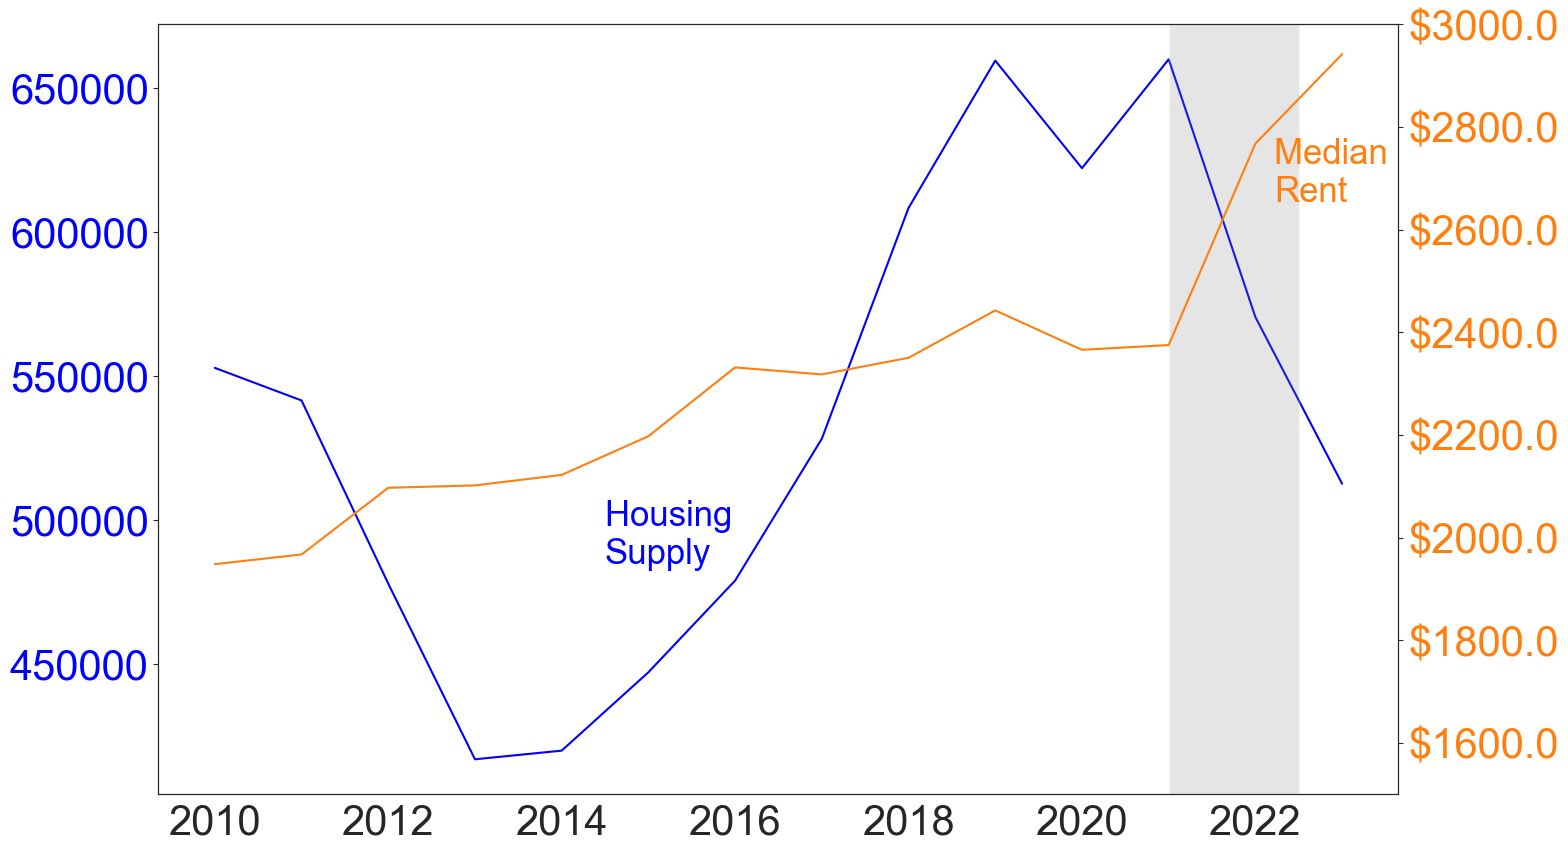

In [91]:

#  Filter the DataFrame for the time range 2018-2022. We are using this subset to avoid some clutter


fig, ax1 = plt.subplots(figsize=(16, 10))

ax1.plot(NYC_rent_housing['Year'], NYC_rent_housing['sum_housing'], label='Housing Supply', color='blue')
ax1.set_xlabel('')
ax1.set_ylabel('', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('')
ax1.tick_params(axis='x', labelsize='large')

plt.tick_params(axis='both', which='major', labelsize=30)

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(NYC_rent_housing['Year'], NYC_rent_housing['rent'], label='Sum of Housing Supply', color='#ff7f0e')
ax2.set_ylabel('', color='#ff7f0e')
ax2.tick_params(axis='y', labelcolor='#ff7f0e')
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'${x}'))
ax2.set_ylim([1500, 3000])


plt.annotate('Housing \nSupply', xy=(0.36,0.3),
xycoords='axes fraction', fontsize= 25, color = 'blue')


plt.annotate('Median \nRent', xy=(0.9,0.77),
xycoords='axes fraction', fontsize= 25, color = '#ff7f0e')


plt.axvspan(2021, 2022.5, facecolor='grey', alpha=0.2)

plt.tick_params(axis='both', which='major', labelsize=30)


plt.savefig('rentvssupply.png', bbox_inches='tight')

plt.savefig('supply_rent.png', dpi=500)

plt.show()




## 3.2. Airbnb Arbitrage Gained Popularity Starting in 2020

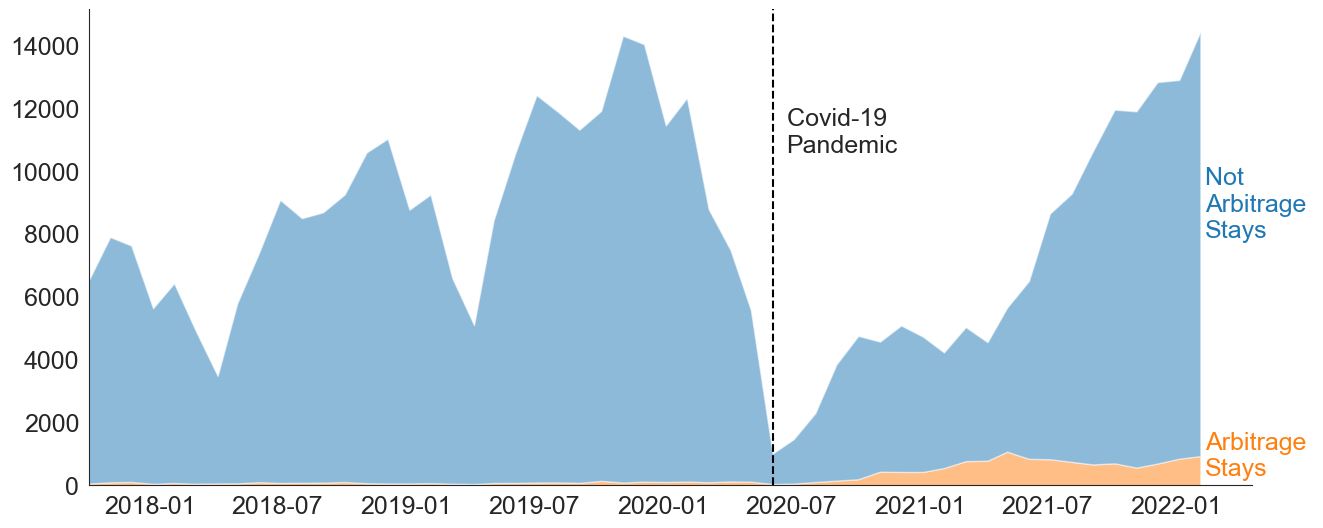

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Date' to datetime format for proper time series analysis
Total_data['Date'] = pd.to_datetime(Total_data['Date'])

# Calculate 'Non-Arbitrage Reviews' by subtracting 'arbitrage_reviews' from 'total_reviews'
Total_data['Non-Arbitrage Reviews'] = Total_data['total_reviews'] - Total_data['arbitrage_reviews']


# Filter the data to include only records after the year 2016
Total_data17 = Total_data[Total_data['Date'] >= pd.to_datetime('2017-08-01')]

# Reshape the data using melt for the stacked area chart
airbnb_melted = pd.melt(Total_data17, id_vars=['Date'], 
                        value_vars=['Non-Arbitrage Reviews', 'arbitrage_reviews'], 
                        var_name='Type', value_name='Number of Stays')

# Aggregate the data to have a single entry per 'Date' and 'Type'
airbnb_aggregated = airbnb_melted.groupby(['Date', 'Type'], as_index=False)['Number of Stays'].sum()

# Pivot the aggregated data for the stacked area chart
pivot_df = airbnb_aggregated.pivot(index='Date', columns='Type', values='Number of Stays')

pivot_df
plt.figure(figsize=(15, 7))
plt.stackplot(pivot_df.index, pivot_df['arbitrage_reviews'], pivot_df['Non-Arbitrage Reviews'], 
              labels=['Arbitrage Reviews', 'Non-Arbitrage Reviews'], 
              colors=['#ff7f0e', '#1f77b4'], alpha=0.5)

# Remove top and right border
ax = plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.annotate('Arbitrage \nStays', xy=(.96,0.02),
xycoords='axes fraction', fontsize= 18, color = '#ff7f0e')


plt.annotate('Not \nArbitrage \nStays', xy=(.96,0.52),
xycoords='axes fraction', fontsize= 18, color = '#1f77b4')


covid_date = pd.to_datetime('2020-04-01')
plt.axvline(covid_date, color='black', linestyle='--')

plt.annotate('Covid-19 \nPandemic', xy=(0.60,0.70),
xycoords='axes fraction', fontsize= 18)



# Adding titles and labels
plt.title('', fontsize=16)
plt.xlabel('')
plt.ylabel('', fontsize=16)
plt.gcf().autofmt_xdate()  
plt.savefig('arbitrageovertime1.png', bbox_inches='tight')
plt.xlim([17380,19035])
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)

plt.savefig('arbi.png', dpi=500)

plt.show()



## 3.3 The Effect of Airbnb Arbitrage on Rent is Mixed (Manhattan vs Brooklyn Case Study)

In [70]:
Airbnb_With_Rent['Arbitrage_Reviews_Change'] = Airbnb_With_Rent.groupby('Borough')['arbitrage_reviews'].pct_change() * 100
Airbnb_With_Rent['MedRent_Change'] = Airbnb_With_Rent.groupby('Borough')['MedRent'].pct_change() * 100


Airbnb_With_Rent = Airbnb_With_Rent.replace([np.inf, -np.inf], np.nan)
Airbnb_With_Rent['Arbitrage_Reviews_Change'] = Airbnb_With_Rent['Arbitrage_Reviews_Change'].fillna(0)
Airbnb_With_Rent['MedRent_Change'] = Airbnb_With_Rent['MedRent_Change'].fillna(0)
Airbnb_With_Rent.tail()



# Convert 'Year' to integer
Airbnb_With_Rent['Year'] = Airbnb_With_Rent['Year'].astype(int)

# Filter the DataFrame for 'Manhattan' and 'Year' > 2018
Manhattan_Brooklyn_filter = Airbnb_With_Rent[(Airbnb_With_Rent['Borough'].isin(['Manhattan','Brooklyn', 'Bronx','Queens'])) & (Airbnb_With_Rent['Year'] > 2019)]
Manhattan_Brooklyn_filter

,Month,Year,Borough,total_reviews,arbitrage_reviews,MedRent,Arbitrage_Reviews_Change,MedRent_Change
45,1,2020,Bronx,337,0.0,1890.720000,0.000000,2.295873
46,1,2020,Brooklyn,3770,20.0,2636.869565,66.666667,7.882545
47,1,2020,Manhattan,3075,71.0,3686.540541,97.222222,3.311064
48,1,2020,Queens,1461,7.0,2090.941176,133.333333,1.295474
50,1,2021,Bronx,162,0.0,1846.608696,0.000000,-2.333043
...,...,...,...,...,...,...,...,...
789,12,2021,Queens,2542,84.0,2146.781250,425.000000,7.594165
791,12,2022,Bronx,1012,0.0,2087.833333,-100.000000,5.766633
792,12,2022,Brooklyn,8581,142.0,3158.729167,97.222222,16.257974
793,12,2022,Manhattan,7333,1226.0,4452.361111,62.169312,10.645921


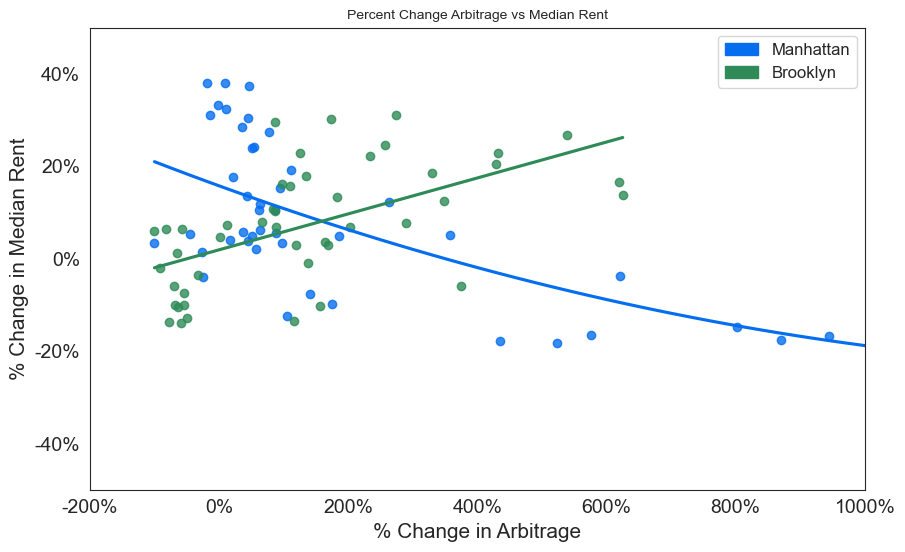

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter

# Assuming Manhattan_Brooklyn_filter is already filtered for 'Manhattan' and 'Brooklyn'

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Plot for Manhattan with a polynomial trend line (e.g., order 2)
sns.regplot(
    data=Manhattan_Brooklyn_filter[Manhattan_Brooklyn_filter['Borough'] == 'Manhattan'], 
    x="Arbitrage_Reviews_Change", 
    y="MedRent_Change", 
    color="#056eee", 
    order=2,  # Polynomial order
    ci=None)   # Remove confidence interval

# Plot for Brooklyn with a polynomial trend line
sns.regplot(
    data=Manhattan_Brooklyn_filter[Manhattan_Brooklyn_filter['Borough'] == 'Brooklyn'], 
    x="Arbitrage_Reviews_Change", 
    y="MedRent_Change", 
    color="seagreen", 
    order=1,  
    ci=None)

# Limiting the y-axis and x-axis
plt.ylim([-50, 50])  # Set specific limits for the y-axis
plt.xlim([-200, 1000])  # Limit to avoid outliers

# Create custom legend
manhattan_patch = mpatches.Patch(color='#056eee', label='Manhattan')
brooklyn_patch = mpatches.Patch(color='seagreen', label='Brooklyn')
legend = plt.legend(handles=[manhattan_patch, brooklyn_patch], fontsize='large')

# Add a title and labels to the plot
plt.title('Percent Change Arbitrage vs Median Rent', fontsize=10)
plt.xlabel('% Change in Arbitrage',fontsize=15)
plt.ylabel('% Change in Median Rent',fontsize=15)

# Function to format tick labels with percent signs
def percent_format(x, pos):
    return f'{int(x)}%'

# Apply percent formatting to the tick labels
plt.gca().xaxis.set_major_formatter(FuncFormatter(percent_format))
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_format))

# Increase the font size of the tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
#plt.savefig('scatter.png', dpi=500)

plt.show()




## 3.4 Airbnb arbitrage Spatial Graph

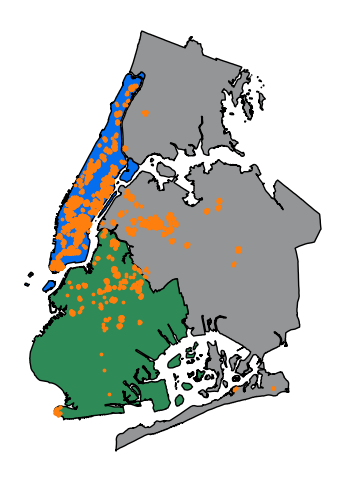

In [103]:
listing_map.columns.tolist()
listing_map = listing_map[['id','host_id','latitude','longitude','neighbourhood_group_cleansed']]
Total=pd.merge(review_map,listing_map, how='left',left_on='listing_id',right_on='id')
Total=Total[['date','listing_id','host_id','neighbourhood_group_cleansed','latitude','longitude']]
Total['date']=pd.to_datetime(Total['date'],format='%Y-%m-%d')
Total.index = Total.date
Total['Year'] = Total.index.year
Total=Total.drop(['date'],axis=1)
Total.reset_index(inplace=True)
Total=Total.drop(['date'],axis=1)
Total_2022=Total[Total['Year']==2022]
hosts_2022 = Total_2022.groupby('host_id')['listing_id'].nunique().reset_index(name='count')
hosts_2022=hosts_2022[hosts_2022['count']>=10]
arbitrage_2022=pd.merge(Total,hosts_2022,how='inner',on='host_id')
arbitrage_2022.drop_duplicates(inplace=True)
geometry = [Point(xy) for xy in zip(arbitrage_2022['longitude'], arbitrage_2022['latitude'])]
arbitrage_2022=gpd.GeoDataFrame(arbitrage_2022,geometry=geometry,crs="EPSG:4269")
arbitrage_2022.head(5)
boros = gpd.read_file(geodatasets.get_path("nybb"))

boro_locations = gpd.tools.geocode(boros.BoroName)
boro_no_staten_island = boros[boros['BoroName'] != 'Staten Island']

# Define your color map. Adjust the borough names and colors as needed.
borough_colors = {
    'Bronx': '#939596',       # Example color for Bronx
    'Brooklyn': 'seagreen',   # Example color for Brooklyn
    'Manhattan': '#056eee',    # Example color for Manhattan
    'Queens': '#939596'     # Example color for Queens
}

# Assuming 'boro_no_staten_island' has a column named 'borough'
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Assign colors to each borough based on the color map
boro_no_staten_island.to_crs("EPSG:4326").plot(ax=ax,
                                               color=boro_no_staten_island['BoroName'].map(borough_colors), edgecolor = 'black')

# Plotting the 'arbitrage_2022' data
arbitrage_2022.plot(ax=ax, marker='o', color='#ff7f0e', markersize=3)

# Removing the axes ticks
ax.set_xticks([])
ax.set_yticks([])

# Hiding the spines/borders of the plot
for spine in ax.spines.values():
    spine.set_visible(False)

# Display the plot
plt.savefig('map.png', dpi=500)

plt.show()


## 3.5 What has NYC Done To Address Airbnb Arbitrage

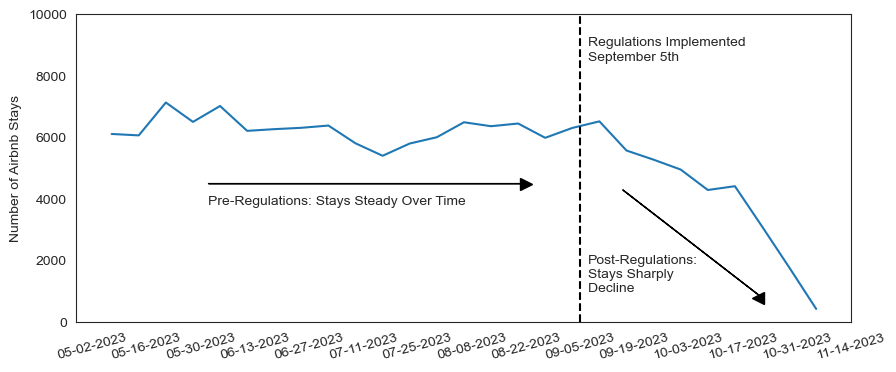

In [96]:
# Here we plot the figure that goes into our conclusion which shows how the number of Airbnb stays has 
# changed since the implementation of NY's new sept 5th regulations

NYC_Reviews_daily = pd.read_csv('DailyReviews.csv')
NYC_Reviews_daily['Date'] = pd.to_datetime(NYC_Reviews_daily['date'], format='%m/%d/%Y')
NYC_Reviews_daily.set_index('Date', inplace=True)
NYC_Reviews_daily.sort_index(inplace=True)

 
September_2023_listings = NYC_Reviews_daily.loc['2023-05-01':'2023-12-05']

# We resample the data to be at a week by week basis 
weekly_counts = September_2023_listings.resample('W').size()


sns.set_style(style='white')
plt.figure(figsize=(10, 4))  
plt.plot(weekly_counts.index, weekly_counts)

# We add a vertical dashed line on September 5th which was when the law was passed
regulation_date = pd.to_datetime('2023-09-05')
plt.axvline(regulation_date, color='black', linestyle='--')


# Manually reformat the dates on the x axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2)) 

plt.xticks(rotation=15)
plt.xlabel('') 
plt.ylabel('Number of Airbnb Stays')
plt.title('') 
plt.ylim(0, 10000)

plt.annotate('Regulations Implemented \nSeptember 5th', xy=(0.66,0.85),
xycoords='axes fraction')

plt.arrow(mdates.date2num(pd.to_datetime('2023-06-01')), 4500, mdates.date2num(pd.to_datetime('2023-08-22')) - mdates.date2num(pd.to_datetime('2023-06-01')), 4500 - 4500, 
          length_includes_head=True, head_width=0.15, head_length=0.5, fc='black', ec='black')

plt.plot(
    mdates.date2num(pd.to_datetime('2023-08-22')),
    4500,
    marker='>',
    markersize=8,
    markerfacecolor='black',
    markeredgecolor='black')


plt.annotate('Pre-Regulations: Stays Steady Over Time  ', xy=(0.17,0.38), xycoords='axes fraction', fontsize = 10 )

plt.arrow(mdates.date2num(pd.to_datetime('2023-09-16')), 4300, mdates.date2num(pd.to_datetime('2023-10-22')) - mdates.date2num(pd.to_datetime('2023-09-16')), 800 - 4300 , 
          length_includes_head=True, head_width=0.15, head_length=0.5, fc='black', ec='black')

plt.plot(
    mdates.date2num(pd.to_datetime('2023-10-21')),
    800,
    marker='<',
    markersize=8,
    markerfacecolor='black',
    markeredgecolor='black')

plt.annotate('Post-Regulations:\nStays Sharply\nDecline  ', xy=(0.66,0.10),
xycoords='axes fraction', fontsize= 10)

plt.savefig('trend.png', dpi=500)

plt.show()


## 3.6 The Effect of Airbnb Arbitrage on Rent is Mixed

In [74]:
# Only keep the Borough data from the demographics dataset

NYC_Demograph = NYC_Demograph.loc[NYC_Demograph['GeoType'] == 'Borough']
NYC_Demograph.head()
# This data comes from the American Community Survey ACS which reports its year column in blocks of 4. For instance 2015-2019, 2016-2020, 2017-2021.
# To make it easier to merge with the other data we will classify the year column based on the last year included in the survey. e.g 2015-2019 -> 2019 and 2016-2020 -> 2020

NYC_Demograph['Time'] = NYC_Demograph['Time'].apply(lambda x: x[:2] + x[5:])
NYC_Demograph.head(20)

# To deal with the NAN population data we found a report with population estimates for 2020 and 2021 across the 5 boroughs. Because there were only 10 values we manually enter them in below using a function.
# To see the pdf report with the data estimates visit https://www.nyc.gov/assets/planning/download/pdf/planning-level/nyc-population/population-estimates/current-population-estimates-2022.pdf?r=a

population_estimates = {
    '2020': {
        'Bronx': 1461125,
        'Brooklyn': 2719044,
        'Manhattan': 1677306,
        'Queens': 2388586,
        'Staten Island': 494586},
    '2021': {
        'Bronx': 1421089,
        'Brooklyn': 2637486,
        'Manhattan': 1578801,
        'Queens': 2328141,
        'Staten Island': 493484}
}


def apply_population_estimate(row):
    year = row['Time']
    borough = row['Geography']
    if year in population_estimates and borough in population_estimates[year]:
        return population_estimates[year][borough]
    return row['Total population']


NYC_Demograph['Total population'] = NYC_Demograph.apply(apply_population_estimate, axis=1)

# Display the head of the DataFrame to verify the changes
NYC_Demograph.head()


# Rename the 'Geography' column to 'Borough'
NYC_Demograph = NYC_Demograph.rename(columns={'Geography': 'Borough'})
# Changing the Borough Column to a Categorical datatype
NYC_Demograph['Borough'] = NYC_Demograph['Borough'].astype('category')
# Rename the Time column to Year
NYC_Demograph.rename(columns={'Time':'Year'},inplace=True)

# Convert the Year column to an int
NYC_Demograph['Year'] = NYC_Demograph['Year'].apply(lambda x: int(x))

NYC_Demograph.head()

,Year,GeoType,GeoID,GeoRank,Borough,Asian alone (percent),Black alone (percent),Hispanic alone (percent),Non-white (percent),Total population,White alone (percent)
353,2021,Borough,1,1,Bronx,3.7,28.5,56.2,91.0,1421089,9.0
354,2021,Borough,2,1,Brooklyn,11.8,28.6,18.8,63.3,2637486,36.7
355,2021,Borough,3,1,Manhattan,11.8,12.1,25.6,53.3,1578801,46.7
356,2021,Borough,4,1,Queens,25.6,16.8,27.9,75.4,2328141,24.6
357,2021,Borough,5,1,Staten Island,10.4,9.1,18.4,40.4,493484,59.6


In [75]:
#cleaning high school grad data

In [76]:
# Only keep the Borough data from the graduated high school dataset

NYC_HSGrad = NYC_HSGrad.loc[NYC_HSGrad['GeoType'] == 'Borough']
NYC_HSGrad.head()
# Drop the columns we do not need for analysis

NYC_HSGrad = NYC_HSGrad.drop(['GeoType','GeoID','GeoRank', 'Number'], axis=1)

# This data comes from the American Community Survey ACS which reports its year column in blocks of 4. For instance 2015-2019, 2016-2020, 2017-2021.
# To make it easier to merge with the other data we will classify the year column based on the last year included in the survey. e.g 2015-2019 -> 2019 and 2016-2020 -> 2020

NYC_HSGrad['Time'] = NYC_HSGrad['Time'].apply(lambda x: x[:2] + x[5:])
NYC_HSGrad.head()

# Rename the 'Geography' column to 'Borough'
NYC_HSGrad = NYC_HSGrad.rename(columns={'Geography': 'Borough'})
# Changing the Borough Column to a Categorical datatype
NYC_HSGrad['Borough'] = NYC_HSGrad['Borough'].astype('category')
# Rename the percent column to HS Grad Rate
NYC_HSGrad.rename(columns={'Percent':'HSGradRate'},inplace=True)
# Rename the Time column to Year
NYC_HSGrad.rename(columns={'Time':'Year'},inplace=True)

# Convert the Year column to an int
NYC_HSGrad['Year'] = NYC_HSGrad['Year'].apply(lambda x: int(x))


In [77]:
NYC_HSGrad.head()

,Year,Borough,HSGradRate
353,2021,Bronx,74.1
354,2021,Brooklyn,83.7
355,2021,Manhattan,88.4
356,2021,Queens,82.7
357,2021,Staten Island,88.6


In [78]:
poverty_table

,Time,GeoType,GeoID,GeoRank,Geography,Number,Percent
0,2017-21,NTA2020,50101,9,Mott Haven-Port Morris,"23,752",43.7
1,2017-21,NTA2020,50102,9,Melrose,"17,284",40.7
2,2017-21,NTA2020,50201,9,Hunts Point,"4,696",34.3
3,2017-21,NTA2020,50202,9,Longwood,"12,751",32.0
4,2017-21,NTA2020,50301,9,Morrisania,"12,615",35.7
...,...,...,...,...,...,...,...
3863,2007-11,Borough,2,1,Brooklyn,"545,963",22.1
3864,2007-11,Borough,3,1,Manhattan,"272,041",17.6
3865,2007-11,Borough,4,1,Queens,"299,650",13.7
3866,2007-11,Borough,5,1,Staten Island,"50,626",11.0


In [79]:
#cleaning the poverty data
# Only keep the Borough data from the poverty dataset

poverty_table = poverty_table.loc[poverty_table['GeoType'] == 'Borough']

# Rename the 'Geography' column to 'Borough'
poverty_table = poverty_table.rename(columns={'Geography': 'Borough'})
# Changing the Borough Column to a Categorical datatype
poverty_table['Borough'] = poverty_table['Borough'].astype('category')
# Drop the columns we do not need for analysis

poverty_table = poverty_table.drop(['GeoType','GeoID','GeoRank', 'Number'], axis=1)
# This data comes from the American Community Survey ACS which reports its year column in blocks of 4. For instance 2015-2019, 2016-2020, 2017-2021.
# To make it easier to merge with the other data we will classify the year column based on the last year included in the survey. e.g 2015-2019 -> 2019 and 2016-2020 -> 2020

poverty_table['Time'] = poverty_table['Time'].apply(lambda x: x[:2] + x[5:])
# Rename the percent column to PovertyRate
poverty_table.rename(columns={'Percent':'PovertyRate'},inplace=True)
# Rename the Time column to Year
poverty_table.rename(columns={'Time':'Year'},inplace=True)

# Convert the Year column to an int
poverty_table['Year'] = poverty_table['Year'].apply(lambda x: int(x))



In [80]:
poverty_table.head()

,Year,Borough,PovertyRate
353,2021,Bronx,26.5
354,2021,Brooklyn,18.8
355,2021,Manhattan,15.6
356,2021,Queens,11.4
357,2021,Staten Island,10.3


In [81]:
NYC_HouseCrowding.head()

,Time,GeoType,GeoID,GeoRank,Geography,Number,Percent
0,2017-21,NTA2020,50101,9,Mott Haven-Port Morris,"2,632",12.9
1,2017-21,NTA2020,50102,9,Melrose,"2,347",15.4
2,2017-21,NTA2020,50201,9,Hunts Point,704,14.4
3,2017-21,NTA2020,50202,9,Longwood,"1,768",12.4
4,2017-21,NTA2020,50301,9,Morrisania,"1,221",9.3


In [82]:
#cleaning the housecrowding data
# Only keep the Borough data from the household crowding dataset

NYC_HouseCrowding = NYC_HouseCrowding.loc[NYC_HouseCrowding['GeoType'] == 'Borough']

# Rename the 'Geography' column to 'Borough'
NYC_HouseCrowding = NYC_HouseCrowding.rename(columns={'Geography': 'Borough'})
# Changing the Borough Column to a Categorical datatype
NYC_HouseCrowding['Borough'] = NYC_HouseCrowding['Borough'].astype('category')
# Drop the columns we do not need for analysis

NYC_HouseCrowding = NYC_HouseCrowding.drop(['GeoType','GeoID','GeoRank', 'Number'], axis=1)
# This data comes from the American Community Survey ACS which reports its year column in blocks of 4. For instance 2015-2019, 2016-2020, 2017-2021.
# To make it easier to merge with the other data we will classify the year column based on the last year included in the survey. e.g 2015-2019 -> 2019 and 2016-2020 -> 2020

NYC_HouseCrowding['Time'] = NYC_HouseCrowding['Time'].apply(lambda x: x[:2] + x[5:])
NYC_HouseCrowding.head()

# Rename the percent column to PovertyRate
NYC_HouseCrowding.rename(columns={'Percent':'Household Crowding Rate'},inplace=True)
# Rename the Time column to Year
NYC_HouseCrowding.rename(columns={'Time':'Year'},inplace=True)

# Convert the Year column to an int
NYC_HouseCrowding['Year'] = NYC_HouseCrowding['Year'].apply(lambda x: int(x))


In [83]:
NYC_HouseCrowding.head()

,Year,Borough,Household Crowding Rate
353,2021,Bronx,12.4
354,2021,Brooklyn,9.9
355,2021,Manhattan,5.7
356,2021,Queens,9.6
357,2021,Staten Island,4.6


In [84]:
NYC_Demograph['Year'] = NYC_Demograph['Year'].astype(int)
NYC_HSGrad['Year'] = NYC_HSGrad['Year'].astype(int)
poverty_table['Year'] = poverty_table['Year'].astype(int)
NYC_HouseCrowding['Year'] = poverty_table['Year'].astype(int)

In [85]:
# Creating a demographics table that will serve as our baseline table which we make manually in 
#powerpoint so that it looks cleaner 


# First we merge all of the data together that is relavant to socioeconomic status 

SocioeconomicData = pd.merge(NYC_Demograph, NYC_HSGrad, on=['Year', 'Borough'])


SocioeconomicData = pd.merge(SocioeconomicData, poverty_table, on=['Year', 'Borough'])

SocioeconomicData = pd.merge(SocioeconomicData, NYC_HouseCrowding, on=['Year', 'Borough'])


# We only want the most recent estimates for Brookyln and Manhattan
SocioeconomicData = SocioeconomicData[(SocioeconomicData['Year'] >= 2021) & (SocioeconomicData['Borough'].isin(['Brooklyn','Manhattan']) )]

#Remove the columns that we do not need

SocioeconomicData = SocioeconomicData.drop(['Asian alone (percent)','Hispanic alone (percent)', 'Black alone (percent)', 'Non-white (percent)','White alone (percent)'], axis=1)

SocioeconomicData

,Year,GeoType,GeoID,GeoRank,Borough,Total population,HSGradRate,PovertyRate,Household Crowding Rate
1,2021,Borough,2,1,Brooklyn,2637486,83.7,18.8,9.9
2,2021,Borough,3,1,Manhattan,1578801,88.4,15.6,5.7


## 3.7. Arbitrage - Rent Correlation Coefficient

In [86]:
# Selecting and slicing the 2022 data for the two boroughs of comparison. 

mht_data=Total_data[Total_data['Borough']=='Manhattan']
mht_data=mht_data[mht_data['Year']>=2020]
bkn_data=Total_data[Total_data['Borough']=='Brooklyn']
bkn_data=bkn_data[bkn_data['Year']>=2020]

In [87]:
# Compute Correlation Coefficient between rent and arbitrage for brooklyn.

bkn_corr=bkn_data[['MedRent','arbitrage_reviews']]
correlation=bkn_corr.corr()
correlation

,MedRent,arbitrage_reviews
MedRent,1.000000,0.583645
arbitrage_reviews,0.583645,1.000000


In [88]:
# Compute Correlation Coefficient between rent and arbitrage for Manhattan. 

mht_corr=mht_data[['MedRent','arbitrage_reviews']]
correlation=mht_corr.corr()
correlation

,MedRent,arbitrage_reviews
MedRent,1.00000,-0.24882
arbitrage_reviews,-0.24882,1.00000


# References:

- http://insideairbnb.com/get-the-data/
- https://streeteasy.com/blog/data-dashboard/?agg=Total&metric=Inventory&type=Rentals&bedrooms=Any%20Bedrooms&property=Any%20Property%20
- https://a816-dohbesp.nyc.gov/IndicatorPublic/beta/data-explorer/economic-conditions/?id=103#display=summary
- https://fred.stlouisfed.org/series/NYKING7POP
- https://fred.stlouisfed.org/series/NYBRON5POP
- https://fred.stlouisfed.org/series/NYNEWY1POP
- https://fred.stlouisfed.org/series/NYQUEE1POP
- https://fred.stlouisfed.org/series/NYRICH5POP
- https://stackoverflow.com/questions/19384532/get-statistics-for-each-group-such-as-count-mean-etc-using-pandas-groupby
- EDA Time Series Lecture
- EDA HW1
- EDA HW2
- EDA Data Wrangling 1 & 2 Lectur
-